# Programming problem 2
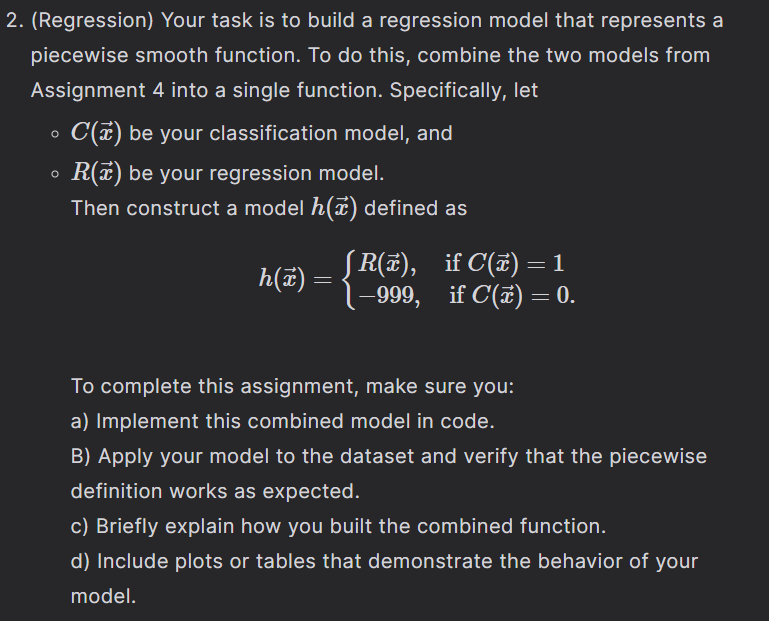

---

## Ref: Assignment 4 Method
* Classification: Random forest
* Regression: Random frest

In [13]:
# ==== 0) 套件 ====
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error

rng_seed = 42


In [18]:
# ==== 1) 讀資料 ====
# 約定：目標欄位如果叫 'y' 或 'label' 或 'target' 就用它，否則用「最後一欄」當目標
def split_Xy(df):
    cand = [c for c in df.columns if c.lower() in ("y","label","target")]
    ycol = cand[0] if cand else df.columns[-1]
    xcols = [c for c in df.columns if c != ycol]
    X = df[xcols].to_numpy(dtype=float)
    y = df[ycol].to_numpy()
    return X, y, xcols, ycol

df_cls = pd.read_csv("classification_dataset.csv")
df_reg = pd.read_csv("regression_dataset.csv")

Xc, yc, xcols_c, ycol_c = split_Xy(df_cls)   # 分類資料（yc 應為0/1）
Xr, yr, xcols_r, ycol_r = split_Xy(df_reg)   # 迴歸資料（yr 為連續值）

# ==== 2) 切資料 ====
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(Xc, yc, test_size=0.25, random_state=rng_seed, stratify=yc)
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr, yr, test_size=0.25, random_state=rng_seed)



In [19]:
# ==== 3) 訓練分類器 C(x) = RandomForestClassifier ====
C = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=5,
    class_weight="balanced",   # 類別不均衡時會比較穩
    random_state=rng_seed,
    n_jobs=-1
)
C.fit(Xc_tr, yc_tr)

yc_pred_te = C.predict(Xc_te)
print(f"[Classifier] acc={accuracy_score(yc_te, yc_pred_te):.3f}")
print("[Classifier] confusion matrix:\n", confusion_matrix(yc_te, yc_pred_te))



[Classifier] acc=0.988
[Classifier] confusion matrix:
 [[1125   11]
 [  13  861]]


In [20]:
# ==== 4) 訓練回歸器 R(x) = RandomForestRegressor ====
# 題目精神：在「有效區域」內平滑回歸 → 只用 C=1 的回歸訓練點來訓練 R
c_on_reg_tr = C.predict(Xr_tr)            # 用分類器去標記回歸訓練資料的有效/無效
mask_tr = (c_on_reg_tr == 1)
if not mask_tr.any():
    print("⚠️ 警告：C 在回歸訓練集沒有預測出 class=1，暫時改用全部回歸訓練資料訓練 R。")
    mask_tr = slice(None)

R = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=5,
    oob_score=True,             # 袋外分數可當 quick CV
    random_state=rng_seed,
    n_jobs=-1
)
R.fit(Xr_tr[mask_tr], yr_tr[mask_tr])
print(f"[Regressor] OOB score (R^2) = {getattr(R, 'oob_score_', np.nan):.3f}")



[Regressor] OOB score (R^2) = 0.832


In [21]:
# ==== 5) 分段函數 h(x) ====
def h(X, C_model, R_model, invalid_value=-999):
    X2 = np.atleast_2d(X)
    c = C_model.predict(X2).ravel()     # 0/1
    r = R_model.predict(X2).ravel()     # 連續值
    out = np.where(c == 1, r, invalid_value)
    return out if len(out) > 1 else out[0]



class-1 count on regression test: 869 / 874
[R on class-1] MAE=1.761  RMSE=2.618
h(x) sample (first 10): [  23.778   25.265 -999.      15.972   21.181   10.966   25.63    16.219
   15.541   25.064]


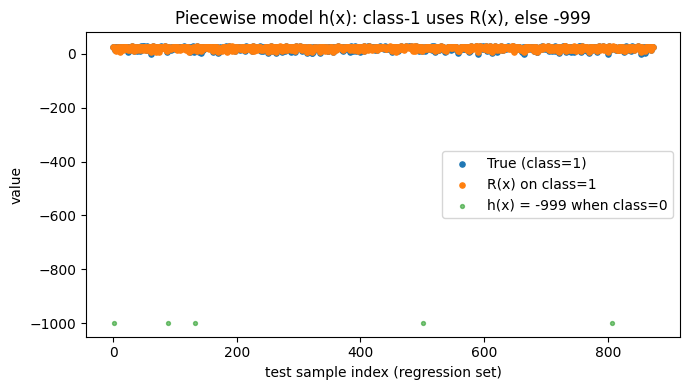

In [22]:
# ==== 6) 在「回歸測試集」上驗證 piecewise 定義 ====
c_on_reg_te = C.predict(Xr_te)
mask_te = (c_on_reg_te == 1)

print("class-1 count on regression test:", mask_te.sum(), "/", len(mask_te))

if mask_te.any():
    yhat_R = R.predict(Xr_te[mask_te])
    mae  = mean_absolute_error(yr_te[mask_te], yhat_R)
    rmse = np.sqrt(mean_squared_error(yr_te[mask_te], yhat_R))
    print(f"[R on class-1] MAE={mae:.3f}  RMSE={rmse:.3f}")
else:
    print("⚠️ 測試集中沒有被分到 class=1 的樣本，無法評估回歸誤差。")

# ==== 7) h(x) 的輸出示範（piecewise 行為） ====
h_te = h(Xr_te, C, R, invalid_value=-999)
print("h(x) sample (first 10):", np.round(h_te[:10], 3))

# ==== 8) 視覺化：展示 h(x) 的分段行為 ====
# 以「回歸測試集」為例：class=1 → 真實值 & 預測值，class=0 → -999 平台
plt.figure(figsize=(7,4))
idx = np.arange(len(Xr_te))

plt.scatter(idx[mask_te], yr_te[mask_te], s=14, label="True (class=1)")
plt.scatter(idx[mask_te], R.predict(Xr_te[mask_te]), s=14, label="R(x) on class=1")
plt.scatter(idx[~mask_te], h_te[~mask_te], s=8, alpha=0.6, label="h(x) = -999 when class=0")

plt.title("Piecewise model h(x): class-1 uses R(x), else -999")
plt.xlabel("test sample index (regression set)")
plt.ylabel("value")
plt.legend()
plt.tight_layout()
plt.show()


---

[R on class-1] MAE=1.761  RMSE=2.618  (n=869)


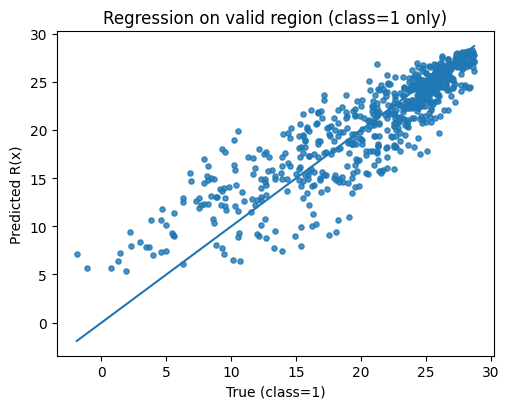

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

c_on_reg_te = C.predict(Xr_te)
mask_te = (c_on_reg_te == 1)

if mask_te.any():
    y_true = yr_te[mask_te]
    y_pred = R.predict(Xr_te[mask_te])

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"[R on class-1] MAE={mae:.3f}  RMSE={rmse:.3f}  (n={mask_te.sum()})")

    # 真實 vs 預測（對角線 y=x）
    plt.figure(figsize=(5.2,4.2))
    plt.scatter(y_true, y_pred, s=14, alpha=0.8)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims)  # y=x
    plt.xlabel("True (class=1)")
    plt.ylabel("Predicted R(x)")
    plt.title("Regression on valid region (class=1 only)")
    plt.tight_layout()
    plt.show()
else:
    print("測試集中沒有被分到 class=1 的樣本。")


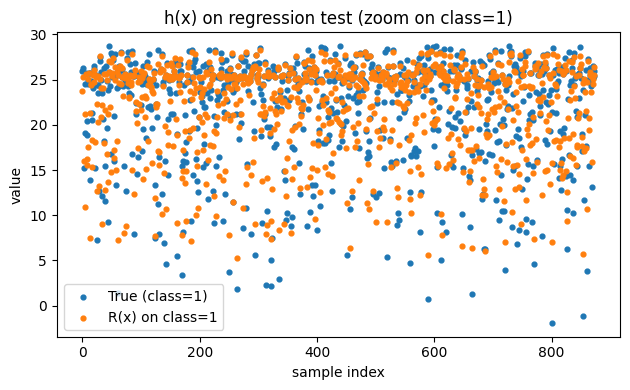

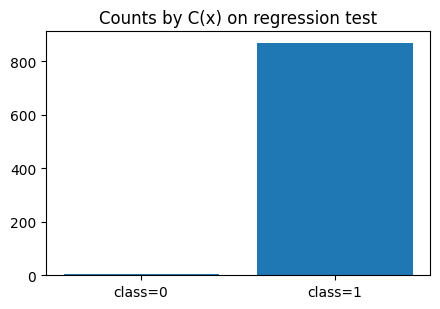

In [24]:
# 1) 主要圖：只看 class=1（避免 -999 壓縮 y 軸）
idx = np.arange(len(Xr_te))
plt.figure(figsize=(6.4,4))
plt.scatter(idx[mask_te], yr_te[mask_te], s=12, label="True (class=1)")
plt.scatter(idx[mask_te], R.predict(Xr_te[mask_te]), s=12, label="R(x) on class=1")
plt.title("h(x) on regression test (zoom on class=1)")
plt.xlabel("sample index"); plt.ylabel("value"); plt.legend(); plt.tight_layout(); plt.show()

# 2) 補充：class=0 的數量（用條狀圖或文字）
n0 = (~mask_te).sum(); n1 = mask_te.sum()
plt.figure(figsize=(4.5,3.2))
plt.bar(["class=0","class=1"], [n0, n1])
plt.title("Counts by C(x) on regression test")
plt.tight_layout(); plt.show()
